In [40]:

%pylab inline

import numpy as np

from PIL import Image

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Populating the interactive namespace from numpy and matplotlib


In [41]:
img_path = 'img/zigbang.png'

In [49]:
img = cv2.imread(img_path)

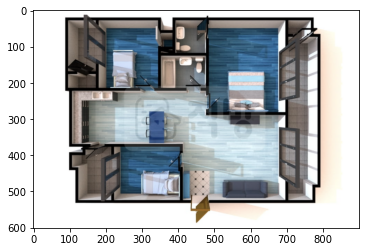

In [50]:
plt.imshow(img)

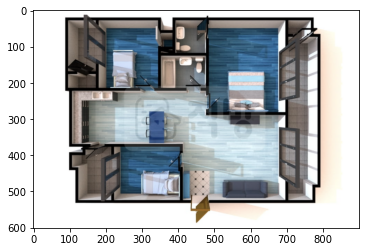

In [51]:
image = cv2.imread(img_path, cv2.COLOR_BGR2RGB )#cv2.IMREAD_COLOR)
plt.imshow(image)

In [53]:
cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

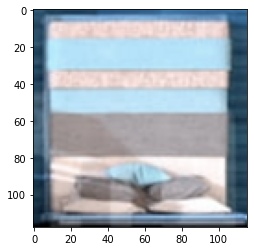

In [81]:
src = cv2.imread('img/src.png')
plt.imshow(src)

(3, 116, 118)

In [85]:
result = cv2.matchTemplate(img , src, cv2.TM_CCOEFF)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
x, y = minLoc
h, w = src.shape[::-1]


for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

#dst = cv2.rectangle(img, (x, y), (x +  w, y + h) , (0, 0, 255), 1)

ValueError: too many values to unpack (expected 2)

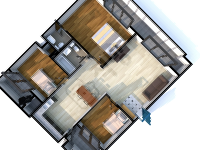

In [24]:
img = Image.open(img_path).resize((200, 150)).rotate(45)
img